In [1]:
import numpy as np
import pandas as pd
from dataProcess.DataClean import CDataClean
from features.zigzag import *
from strategy.TrendlineScalping import *

epsilon = 1e-6
CDC = CDataClean('/Users/Administrator/Desktop/pythonHistoricalTesting/data/USA30.IDXUSD_Candlestick_15_M_BID_15.04.2018-20.11.2020.csv')
df_c = CDC.TranslateCsvToDF_NotDropDuplicates()
df_c = df_c.loc[df_c.Volume > epsilon].reset_index(drop=True)
# df_c = df_c[:5000]

In [2]:
from USA30DataProcess.Min15 import *
df_c = NewOpenBar(df_c)

In [3]:
openBarInfo = []
for index, row in df_c.loc[df_c.IsOpenBar != ' '].iterrows():
    openBarInfo.append([index, row['Open']])
openBarInfo = np.array(openBarInfo)

In [4]:
pipDistanceWithOpen = [None] * (int(openBarInfo[0][0])) # 给第一个交易日开盘前的位置赋空值

for openIdx1, openPrice1, openIdx2, openPrice2 in zip(openBarInfo[:-1,0], openBarInfo[:-1,1], openBarInfo[1:,0], openBarInfo[1:,1]):
    
    for i in range(int(openIdx1), int(openIdx2)): # 给第一个交易日至最后一个交易日之间的位置赋值
        
        pipDistanceWithOpen.append(df_c.loc[i].Close - openPrice1)

for i in range(int(openBarInfo[-1][0]), len(df_c)): # 给最后一天添加值
               
    pipDistanceWithOpen.append(df_c.loc[i].Close - openBarInfo[-1][1])

df_c['PipDistanceWithOpen'] = pipDistanceWithOpen

In [5]:
constPips = 10
reversalPips = 50

In [6]:
CZZ = ZigZag(df_c, reversalPips, 'amount')
zzpDF = CZZ.fixed_zzps()
zzpDF['Type'] = [str(zzpDF.type_[i]) for i in range(len(zzpDF))]

In [7]:
from features.Technics import IdentifyRsi
from features.Technics import IdentifyMfi
from features.Technics import IdentifyEma

In [8]:
df_c = IdentifyRsi(df_c) # [RSI]
df_c = IdentifyMfi(df_c) # [MFI]
df_c = IdentifyEma(df_c,7) # [EMA7]
df_c = IdentifyEma(df_c,20) # [EMA20]
df_c['IsTodayYangBar'] = df_c['PipDistanceWithOpen'] > 0
df_c['IsYangBar'] = df_c['Close'] > df_c['Open']
df_c['IsRsiOver50'] = df_c['RSI'] > 50
df_c['IsMfiOver50'] = df_c['MFI'] > 50
df_c['IsEmaShortOverLong'] = df_c['EMA7'] > df_c['EMA20']

longSeries = (df_c['Close'] < df_c['EMA7']) & (df_c['Close'] > df_c['EMA20'] - constPips)
longSeries = [False] + longSeries[1:].values.tolist()

df_c['LongPositionRule6'] = longSeries

df_c['IsTodayYinBar'] = df_c['PipDistanceWithOpen'] < 0
df_c['IsYinBar'] = df_c['Close'] < df_c['Open']
df_c['IsRsiUnder50'] = df_c['RSI'] < 50
df_c['IsMfiUnder50'] = df_c['MFI'] < 50
df_c['IsEmaShortUnderLong'] = df_c['EMA7'] < df_c['EMA20']

shortSeries = (df_c['Close'] > df_c['EMA7']) & (df_c['Close'] < df_c['EMA20'] + constPips)
shortSeries = [False] + shortSeries[1:].values.tolist()

df_c['ShortPositionRule6'] = shortSeries

In [9]:
longFeatureDF = df_c[['IsTodayYangBar','IsYangBar','IsRsiOver50','IsMfiOver50','IsEmaShortOverLong','LongPositionRule6']]
longPositionIndex = []
for index, row in longFeatureDF.iterrows():
    if(np.all(row) == True):
        longPositionIndex.append(index)

In [10]:
shortFeatureDF = df_c[['IsTodayYinBar','IsYinBar','IsRsiUnder50','IsMfiUnder50','IsEmaShortUnderLong','ShortPositionRule6']]
shortPositionIndex = []
for index, row in shortFeatureDF.iterrows():
    if(np.all(row) == True):
        shortPositionIndex.append(index)

In [11]:
zzpLowDF = zzpDF.loc[zzpDF.Type == 'ZZPType.LOW_ZZP'].reset_index(drop=True)
zzpHighDF = zzpDF.loc[zzpDF.Type == 'ZZPType.HIGH_ZZP'].reset_index(drop=True)

In [12]:
zzpHigh_Bar_Num = zzpHighDF.bar_num.values
zzpLow_Bar_Num = zzpLowDF.bar_num.values

In [13]:
extremeHighIdx = []
longPositionIdx = []

for longIdx in longPositionIndex:
    targetRow_zzpHighDF = ((zzpHigh_Bar_Num - longIdx) > 0).argmax()
    if(targetRow_zzpHighDF > 0):
        targetRow_zzpHighDF = targetRow_zzpHighDF - 1
        
#         print('zzpHigh_Bar_Num[targetRow_zzpHighDF]: ',zzpHigh_Bar_Num[targetRow_zzpHighDF])
#         print('longIdx: ',longIdx)
#         print('===============================')

        assert(zzpHigh_Bar_Num[targetRow_zzpHighDF] <= longIdx)
        extremumHigh = zzpHighDF.iloc[targetRow_zzpHighDF].extremum
        previousDF_c = df_c[:zzpHigh_Bar_Num[targetRow_zzpHighDF]].iloc[::-1]
        previousDF_c = df_c[:longIdx].iloc[::-1]
        
        i = 0
        flag = 0
        while(flag == 0):
#             print('i: ',i)
#             print('len(previousDF_c): ',len(previousDF_c))
#             print('previousDF_c.iloc[i].High: ',previousDF_c.iloc[i].High)
#             print('extremumHigh: ',extremumHigh)
#             print('minusResult: ',previousDF_c.iloc[i].High - extremumHigh)
#             print('===============================')
            
            minusResult = previousDF_c.iloc[i].High - extremumHigh
            if(minusResult < 1e-6 and minusResult > -1e-6): # 找到最高点实际对应的index
                
#                 print('calc extremumHigh index: ',longIdx - 1 - i)
#                 print('calc extremumHigh value: ',df_c.loc[longIdx - 1 -  i].High)
#                 print('real extremumHigh value: ',extremumHigh)
#                 print('===============================')

                extremeHighIdx.append(longIdx - 1 - i)
                longPositionIdx.append(longIdx)
                flag = 1
            
            if(i > 300): # Bug 解决不掉，先这么设定回头再改
                
                flag = 2
            
            i += 1

finalLongPositionIdx = []

for e,l in zip(extremeHighIdx,longPositionIdx):
    
#     print(e, ' ',l)
#     print(df_c.loc[e].High - df_c.loc[l].Open)
#     print('===============================')
    
    if(df_c.loc[e].High - df_c.loc[l].Open > 0): # 实时Bar开盘价 < 前期极高点最高价，此时有进场的机会
        
        pressureLineBroken = IsPressureLineBroken(e,l,df_c)
        
        if(pressureLineBroken): finalLongPositionIdx.append([l, e]) # 把e也添加进输出是为了方便作图

In [14]:
extremeLowIdx = []
shortPositionIdx = []

for shortIdx in shortPositionIndex:
    targetRow_zzpLowDF = ((zzpLow_Bar_Num - shortIdx) > 0).argmax()
    if(targetRow_zzpLowDF > 0):
        targetRow_zzpLowDF = targetRow_zzpLowDF - 1
        assert(zzpLow_Bar_Num[targetRow_zzpLowDF] <= shortIdx)
        extremumLow = zzpLowDF.iloc[targetRow_zzpLowDF].extremum
        previousDF_c = df_c[:shortIdx].iloc[::-1]
        
        i = 0
        flag = 0
        while(flag == 0):
            minusResult = previousDF_c.iloc[i].Low - extremumLow
            if(minusResult < 1e-6 and minusResult > -1e-6):
#                 print('calc extremumLow index: ',shortIdx - 1 - i)
#                 print('calc extremumLow value: ',df_c.loc[shortIdx - 1 -  i].Low)
#                 print('real extremumLow value: ',extremumLow)
#                 print('===============================')
                extremeLowIdx.append(shortIdx - 1 - i)
                shortPositionIdx.append(shortIdx)
                flag = 1
            
            if(i > 300): # Bug 解决不掉，先这么设定回头再改
                
                flag = 2
            
            i += 1

finalShortPositionIdx = []            

for e,s in zip(extremeLowIdx,shortPositionIdx):
    
#     print(e, ' ',s)
#     print(df_c.loc[e].High - df_c.loc[s].Open)
#     print('===============================')
    
    if(df_c.loc[e].Low - df_c.loc[s].Open < 0): # 前期极低点最低价 < 实时Bar开盘价，此时有进场的机会
        
        supportLineBroken = IsSupportLineBroken(e,s,df_c)
        
        if(supportLineBroken): finalShortPositionIdx.append([s, e]) # 把e也添加进输出是为了方便作图           


In [15]:
finalLongPositionIdx = np.array(finalLongPositionIdx)
finalShortPositionIdx = np.array(finalShortPositionIdx)

多单/空单离场Index计算

In [16]:
stopLossPips = 100
takeProfitPips = 100

finalLongPositionIdx_addEP = []

for fl, lh in zip(finalLongPositionIdx[:,0],finalLongPositionIdx[:,1]):
    
    entryPrice = df_c.loc[fl].Close
    stopLossPrice = entryPrice - stopLossPips
    takeProfitPrice = entryPrice + takeProfitPips
    
    closeAfterEntry = df_c.loc[fl:].Close.values
    
    pt = (closeAfterEntry - takeProfitPrice > 0).argmax()
    ps = (closeAfterEntry - stopLossPrice < 0).argmax()
    
    if(pt == 0 and ps == 0):
        finalLongPositionIdx_addEP.append([fl, fl+len(closeAfterEntry, lh, 'Buy')])
    elif(pt == 0 and ps != 0):
        finalLongPositionIdx_addEP.append([fl, fl+ps, lh, 'Buy'])
    elif(pt != 0 and ps == 0):
        finalLongPositionIdx_addEP.append([fl, fl+pt, lh, 'Buy'])
    else:
        if(ps > pt):
            finalLongPositionIdx_addEP.append([fl, fl+pt, lh, 'Buy'])
        else:
            finalLongPositionIdx_addEP.append([fl, fl+ps, lh, 'Buy'])

finalShortPositionIdx_addEP = []

for fs, ll in zip(finalShortPositionIdx[:,0],finalShortPositionIdx[:,1]):
    
    entryPrice = df_c.loc[fs].Close
    stopLossPrice = entryPrice + stopLossPips
    takeProfitPrice = entryPrice - takeProfitPips
    
    closeAfterEntry = df_c.loc[fs:].Close.values
    
    pt = (closeAfterEntry - takeProfitPrice < 0).argmax()
    ps = (closeAfterEntry - stopLossPrice > 0).argmax()
    
    if(pt == 0 and ps == 0):
        finalShortPositionIdx_addEP.append([fs, fs+len(closeAfterEntry), ll, 'Sell'])
    elif(pt == 0 and ps != 0):
        finalShortPositionIdx_addEP.append([fs, fs+ps, ll, 'Sell'])
    elif(pt != 0 and ps == 0):
        finalShortPositionIdx_addEP.append([fs, fs+pt, ll, 'Sell'])
    else:
        if(ps > pt):
            finalShortPositionIdx_addEP.append([fs, fs+pt, ll, 'Sell'])
        else:
            finalShortPositionIdx_addEP.append([fs,fs+ps, ll, 'Sell'])

生成历史记录表

In [17]:
history_form = []
#draw_form = [] ''' 建仓index, 离场index, 前期zzp_High/zzp_Low index, 建仓方向  '''


for fl in finalLongPositionIdx_addEP:
    row_c = df_c.loc[fl[0]]
    row_e = df_c.loc[fl[1]]
    history_form.append([row_c.GMT, 'Buy', 1.0, 'USA30', row_c.Close, row_c.Close - stopLossPips, row_c.Close + takeProfitPips, row_e.GMT, row_e.Close, 0.0, row_e.Close-row_c.Close])
    
for fs in finalShortPositionIdx_addEP:
    row_c = df_c.loc[fs[0]]
    row_e = df_c.loc[fs[1]]
    history_form.append([row_c.GMT, 'Sell', 1.0, 'USA30', row_c.Close, row_c.Close + stopLossPips, row_c.Close - takeProfitPips, row_e.GMT, row_e.Close, 0.0, row_c.Close-row_e.Close])

history = pd.DataFrame(data=history_form, columns=['CP_GMT', 'OrderType', 'CP_Lots', 'Symbol', 'CP_Price', 'StopLoss', 'TakeProfit', 'EP_GMT', 'EP_Price', 'InventoryFee', 'Profits'])
history = history.sort_values(by=['CP_GMT']).reset_index(drop=True)
history

,CP_GMT,OrderType,CP_Lots,Symbol,CP_Price,StopLoss,TakeProfit,EP_GMT,EP_Price,InventoryFee,Profits
0,2018-04-18 13:30:00,Buy,1.0,USA30,24805.170,24705.170,24905.170,2018-04-19 12:45:00,24673.070,0.0,-132.100
1,2018-04-25 10:30:00,Sell,1.0,USA30,23965.070,24065.070,23865.070,2018-04-25 13:30:00,23839.670,0.0,125.400
2,2018-04-27 16:30:00,Sell,1.0,USA30,24279.170,24379.170,24179.170,2018-04-30 01:45:00,24385.469,0.0,-106.299
3,2018-04-27 19:30:00,Buy,1.0,USA30,24303.670,24203.670,24403.670,2018-04-30 05:15:00,24406.470,0.0,102.800
4,2018-04-27 19:45:00,Buy,1.0,USA30,24311.670,24211.670,24411.670,2018-04-30 05:30:00,24412.470,0.0,100.800
...,...,...,...,...,...,...,...,...,...,...,...
334,2020-11-16 07:30:00,Buy,1.0,USA30,29755.239,29655.239,29855.239,2020-11-16 11:45:00,29961.599,0.0,206.360
335,2020-11-16 19:45:00,Sell,1.0,USA30,29838.789,29938.789,29738.789,2020-11-16 20:45:00,29960.789,0.0,-122.000
336,2020-11-18 15:00:00,Buy,1.0,USA30,29875.999,29775.999,29975.999,2020-11-18 18:15:00,29738.779,0.0,-137.220
337,2020-11-18 15:15:00,Buy,1.0,USA30,29881.759,29781.759,29981.759,2020-11-18 18:15:00,29738.779,0.0,-142.980


In [18]:
history.CP_GMT.loc[0]

Timestamp('2018-04-18 13:30:00')

In [19]:
history.tail(3)

,CP_GMT,OrderType,CP_Lots,Symbol,CP_Price,StopLoss,TakeProfit,EP_GMT,EP_Price,InventoryFee,Profits
336,2020-11-18 15:00:00,Buy,1.0,USA30,29875.999,29775.999,29975.999,2020-11-18 18:15:00,29738.779,0.0,-137.22
337,2020-11-18 15:15:00,Buy,1.0,USA30,29881.759,29781.759,29981.759,2020-11-18 18:15:00,29738.779,0.0,-142.98
338,2020-11-18 15:45:00,Buy,1.0,USA30,29881.499,29781.499,29981.499,2020-11-18 18:15:00,29738.779,0.0,-142.72


In [20]:
history.to_csv('./code_generated_csv/historical_trading_data.csv')

In [21]:
np.sum(history.Profits)

5058.257999999954

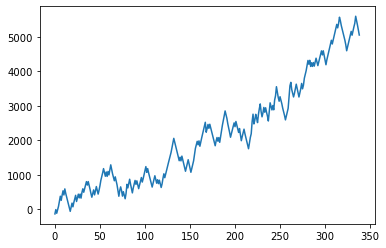

In [22]:
profit = history.Profits.values

P = []

sumP = 0

for p in profit:
    
    sumP += p
    
    P.append(sumP)

import matplotlib.pyplot as plt
plt.plot(P)    

In [23]:
orderNumber = len(history.loc[history.Profits != 0])
totalP = np.sum(history.Profits)
meanP = np.sum(history.Profits)/history.Profits.size
winPercentage = len(history.loc[history.Profits > 0])/len(history.loc[history.Profits != 0])

(orderNumber,totalP,meanP,winPercentage)

(339, 5058.257999999954, 14.921115044247653, 0.5427728613569321)

In [24]:
# pd.concat([history,draw],axis = 1)

生成作图信息表

In [25]:
draw_form = finalLongPositionIdx_addEP + finalShortPositionIdx_addEP
draw = pd.DataFrame(data=draw_form, columns=['CP_Index','EP_Index','Last_ZZP_Index', 'OrderType'])
draw = draw.sort_values(by=['CP_Index']).reset_index(drop=True)
draw

,CP_Index,EP_Index,Last_ZZP_Index,OrderType
0,240,326,232,Buy
1,673,685,668,Sell
2,875,903,872,Sell
3,887,917,885,Buy
4,888,918,885,Buy
...,...,...,...,...
334,59098,59115,59094,Buy
335,59147,59151,59142,Sell
336,59306,59319,59305,Buy
337,59307,59319,59305,Buy


In [26]:
# df_c.to_csv('./code_generated_csv/df_c.csv')

In [27]:
# 去df_c找，把行当参数
import datetime
import numpy as np
import mpl_finance as mpf  # 替换 import matplotlib.finance as mpf
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=14)  
# 这个是style的内置风格 
plt.style.use('fivethirtyeight')

D:\anaconda\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [28]:
def Strategy2Draw(df_draw,df_c,Idx):
    '''
    Idx表示df_draw的index
    '''
    fig = plt.figure(figsize=(50, 30), dpi=400, facecolor="white")
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    Last_ZZP_Index = df_draw.loc[Idx].Last_ZZP_Index
    Enter_bar_Idx = df_draw.loc[Idx].CP_Index
    if df_draw.loc[Idx].OrderType == 'Buy':
        ExtremePointPrice = df_c.loc[Last_ZZP_Index].High
    else:
        ExtremePointPrice = df_c.loc[Last_ZZP_Index].Low
    
    EnterClose = df_c.loc[Enter_bar_Idx].Close
    
    Exit_bar_Idx = df_draw.loc[Idx].EP_Index
    ExitClose = df_c.loc[Exit_bar_Idx].Close
    
    StartIdx = Enter_bar_Idx - 50
    EndIdx = Exit_bar_Idx + 30
    df = df_c.loc[StartIdx:EndIdx]#去df_c中找到所有需要绘制的idx的k线信息
    mpf.candlestick2_ochl(ax1,df.Open, df.Close, df.High, df.Low, width=1,colorup='g', colordown='r')
    ax1.tick_params(labelsize=40)
    ax1.plot(Enter_bar_Idx - StartIdx,EnterClose,'ks')#用收盘价标记入场点
    line1, = ax1.plot(df.index - StartIdx,df.EMA7,label = 'EMA7')
    line2, = ax1.plot(df.index - StartIdx,df.EMA20,label = 'EMA20')
    ax1.legend([line1,line2],['EMA7','EMA20'])
    #在入场点标记方向,若是做空标记下三角，做多标记上三角
    if df_draw.loc[Idx].OrderType == 'Buy':
        ax1.plot(Enter_bar_Idx - StartIdx,EnterClose,marker = '^',markerfacecolor='c',markersize = 30)
    else:
        ax1.plot(Enter_bar_Idx - StartIdx,EnterClose,marker = 'v',markerfacecolor='c',markersize = 30)
        
    ax1.plot(Exit_bar_Idx - StartIdx,ExitClose,'ks',markersize = 20)#用收盘价标记出场点
    #绘制两点间的连线
    x = [[Last_ZZP_Index - StartIdx, Enter_bar_Idx - StartIdx]] # 要连接的两个点的坐标
    y = [[ExtremePointPrice, EnterClose]]

    for i in range(len(x)):
        ax1.plot(x[i], y[i], color='k')
        ax1.scatter(x[i], y[i], color='b')
    ax2.axvline(x = Enter_bar_Idx,ls="-",c="black")#添加垂直直线   
    ax2.tick_params(labelsize=40)
    l1, = ax2.plot(df.RSI,label = 'RSI')
    l2, = ax2.plot(df.MFI,label = 'MFI')
    
    ax2.legend([l1,l2],['RSI','MFI'])
    plt.show()
    fig.savefig('./code_generated_pic/{}.jpg'.format(Enter_bar_Idx))

In [29]:
Strategy2Draw(draw,df_c,2)